
# Exercise Sheet No. 10

---

> Machine Learning for Natural Sciences, Summer 2023, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: July 11th 2023, 8:00 am
>
> Container version 1.0.1
>
> Tutor: patrick.reiser@kit.edu
>
> **Please ask questions in the forum/discussion board and only contact the Tutor when there are issues with the grading**
---

---

**Topic**: This exercise sheet will introduce you to machine learning on graphs.

# Graph Theory
From [wikipedia](https://en.wikipedia.org/wiki/Graph_theory): "In mathematics, graph theory is the study of graphs, which are mathematical structures used to model pairwise relations between objects. A graph in this context is made up of vertices (also called nodes or points) which are connected by edges (also called links or lines). A distinction is made between undirected graphs, where edges link two vertices symmetrically, and directed graphs, where edges link two vertices asymmetrically. Graphs are one of the principal objects of study in discrete mathematics."

In one restricted but very common sense of the term, a graph is an ordered pair $G = ( V , E )$ comprising:

* The vertex set $V$ of vertices (also called nodes or points);
* The edge set $E\subseteq \{ \{x, y\} \mid x, y \in V \}$ edges (also called links or lines), which are unordered pairs of vertices (that is, an edge is associated with two distinct vertices).

To avoid ambiguity, this type of object may be called precisely an undirected simple graph. 

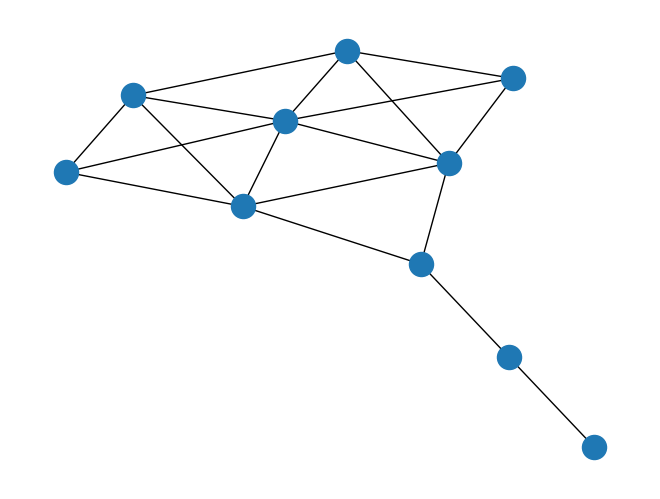

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Example of a graph
G = nx.krackhardt_kite_graph()
nx.draw(G, pos=nx.kamada_kawai_layout(G))

# Graph convolutional neural networks (GCN)

Graph convolutional neural networks are a natural extension of CNNs for graph-structured data. A simple but efficient Graph Neural Network was introduced in ["Semi-Supervised Classification with Graph Convolutional Networks"](https://arxiv.org/abs/1609.02907) by Kipf et al. (2016). Below is a description of the model and its applications taken are from https://tkipf.github.io/graph-convolutional-networks/. We will implement this model and test it on some graph data.

### GCNs Part I: Definitions

Currently, most graph neural network models have a somewhat universal architecture in common. We will refer to these models as Graph Convolutional Networks (GCNs); convolutional, because filter parameters are typically shared over all locations in the graph (or a subset thereof as in [Duvenaud et al., NIPS 2015](https://proceedings.neurips.cc/paper/2015/hash/f9be311e65d81a9ad8150a60844bb94c-Abstract.html)).

For these models, the goal is then to learn a function of signals/features on a graph $G = (V, E)$ which takes as input:

* A feature description $x_i$ for every node $i$; summarized in a $N\times D$ feature matrix $X$ ($N$: number of nodes, $D$: number of input features)
* A representative description of the graph structure in matrix form; typically in the form of an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) $A$ (or some function thereof)

and produces a node-level output $Z$ (an $N\times F$ feature matrix, where $F$ is the number of output features per node). Graph-level outputs can be modeled by introducing some form of pooling operation (see, e.g. [Duvenaud et al., NIPS 2015](https://proceedings.neurips.cc/paper/2015/hash/f9be311e65d81a9ad8150a60844bb94c-Abstract.html)).

Every neural network layer can then be written as a non-linear function

$$H^{(l+1)}=f(H^{(l)}, A),$$

with $H^{(0)}=X$ and $H^{(L)}=Z$ (or $z$ for graph-level outputs), $L$ being the number of layers. The specific models then differ only in how $f(⋅,⋅)$ is chosen and parameterized.

### GCNs Part II: A simple example

As an example, let's consider the following very simple form of a layer-wise propagation rule:

$$f(H^{(l)},A)= \sigma (AH^{(l)}W^{(l)}),$$

where $W^{(l)}$ is a weight matrix for the $l$-th neural network layer and $\sigma(⋅)$ is a non-linear activation function like the ReLU. Despite its simplicity this model is already quite powerful (we'll come to that in a moment).

But first, let us address two limitations of this simple model: multiplication with $A$ means that, for every node, we sum up all the feature vectors of all neighboring nodes but not the node itself (unless there are self-loops in the graph). We can "fix" this by enforcing self-loops in the graph: we simply add the identity matrix to $A$.

The second major limitation is that $A$ is typically not normalized and therefore the multiplication with $A$ will completely change the scale of the feature vectors proportional to a node's degree. Normalizing $A$ such that all rows sum to one, i.e. $D^{−1}A$, where $D$ is the diagonal node degree matrix, gets rid of this problem. Multiplying with $D^{−1}A$ now corresponds to taking the average of neighboring node features. In practice, dynamics get more interesting when we use a symmetric normalization, i.e. $D^{−\frac{1}{2}} A D^{−\frac{1}{2}}$ (as this no longer amounts to mere averaging of neighboring nodes). Combining these two tricks, we essentially arrive at the propagation rule introduced in [Kipf & Welling](https://arxiv.org/abs/1609.02907) (ICLR 2017):

$$f(H^{(l)},A)=\sigma \, ( \hat{D}^{−\frac{1}{2}} \hat{A} \hat{D}^{−\frac{1}{2}} H^{(l)}W^{(l)}),$$

with $\hat{A}=A+I$, where $I$ is the identity matrix and $\hat{D}$ is the diagonal node degree matrix of $\hat{A}$.

For a better understanding, let us additionally build the connection between Message Passing Networks and Graph (Convolutional) Networks.
In the message passing framework, for each node $v$, on each iteration $t$ we construct messages
$$m_{v}^{t+1} = \sum_{w \in N(v)} M_{t}(h_{v}^{t},h_{w}^{t},e_{vw})$$
and updates of a node's hidden state
$$h_{v}^{t+1} = U(h_{v}^{t}, m_{v}^{t+1})$$

with $h_{v}^{0}$ being the initial features of node $v$.
While the matrix formulation may seem unrelated to the message passing framework at first sight, it is in fact one particular instance of message passing.

Let $G = (V, E)$ be a graph and $n = |V|$. Let $A \in \mathbb{R}^{n \times n}$ be the graph's adjacency matrix induced by $E$. Let $X \in \mathbb{R}^{n \times D}$ be the node feature tensor. We use the slice notation as in Python, numpy, TensorFlow or PyTorch, i.e., $A_{0:}$ indexes the first row of $A$ which indicates
whether node $0$ is connected to nodes $0 .. n$.

The dot product $A_{0:}X$ then effectively performs two steps. First, during the multiplication step of the dot product, the $0-1$ entries of the row act as a (convolutional) filter on the node feature tensor $X$ by pointwise products, i.e., they define $N(v)$. Second, during the addition step of the dot product, $\sum_{w \in N(v)}$ is calculated. Since we do not perform any additional steps during message construction, our message function is simply $M_{t}(h_{v}^{t},h_{w}^{t},e_{vw}) = h_{w}^{t}.$

Similarly, as we do not have any further operations to perform via matrix multiplication, our update function is thus $h_{v}^{t+1} = U(h_{v}^{t}, m_{v}^{t+1})= m_{v}^{t+1}$.

Therefore, $AX$ effectively performs a full graph convolution step via matrix multiplication. As a result, the modification (like normalizing it) of $A$ results in a different filter and in turn yields a different node and graph representation. This vectorized implementation is especially efficient for dense graphs. For large sparse graphs, sparse matrix multiplication or edge lists are preferred due to the large number of multiplications by 0.


Next, we will take a closer look at how this type of model operates on a very simple example graph: Zachary's karate club network (make sure to check out the [Wikipedia article](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)!). A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split.

Example of labels[5:15] : ['Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Officer', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Officer']


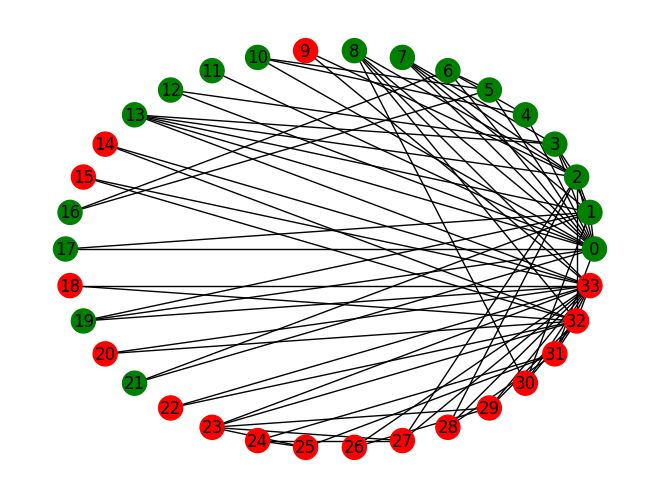

In [2]:
G = nx.karate_club_graph()
labels = [G.nodes()[i]["club"] for i in range(nx.number_of_nodes(G))]
print("Example of labels[5:15] :", labels[5:15])
labels_onehot = [0 if x == "Mr. Hi" else 1 for x in labels]
labels_color = ["green" if x == "Mr. Hi" else "red" for x in labels]
nx.draw_circular(G, with_labels=True, node_color=labels_color)
plt.show()

In [3]:
import scipy
import scipy.sparse as sp
import numpy as np

# Adjacency matrix as sparse matrix
A = nx.adjacency_matrix(G)
print(A.toarray())

[[0 4 5 ... 2 0 0]
 [4 0 6 ... 0 0 0]
 [5 6 0 ... 0 2 0]
 ...
 [2 0 0 ... 0 4 4]
 [0 0 2 ... 4 0 5]
 [0 0 0 ... 4 5 0]]


### 10.1 Normalized adjacency matrix
Compute the normalized adjacency matrix $A_{norm} = \hat{D}^{−\frac{1}{2}} \hat{A} \hat{D}^{−\frac{1}{2}}$, with $\hat{A}=A+I$, where $I$ is the identity matrix and $\hat{D}$ is the diagonal node degree matrix of $\hat{A}$.
You have to implement ``compute_normalized_adj`` using scipy's sparse matrix functions, such as `.sum`, `sp.diag`, `sp.eye`, `.shape`, `.transpose` and `.dot`. It is okay to compute the power of the row- and column sum with `numpy`. You may have to check for `np.inf` here when taking $\hat{D}^{−\frac{1}{2}}$.

In [18]:
def compute_normalized_adj(adj):
    """Compute scaled adjacency matrix D^-0.5*(A + I)*D^-0.5
    with the degree matrix D of (A+I).
    
    Args:
        adj (scipy.sparse): Sparse matrix representation of A with shape (N, N)
    
    Returns:
        sp.sparse.coo_matrix: Sparse matrix representation of D^-0.5*(A + I)*D^-0.5
    """
    # YOUR CODE HERE
    adj = adj + sp.eye(adj.shape[0])
    d = np.array(adj.sum(1))
    d_inv_sqrt = np.power(d, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    a_norm = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    #raise NotImplementedError()
    return a_norm

In [19]:
# test on the Karate Club network
A_norm = compute_normalized_adj(A)

In [20]:
assert isinstance(A_norm, scipy.sparse.coo_matrix)

test_arr_1 = np.array([
    [0.023256, 0.111369, 0.130766, 0.104957, 0.152499],
    [0.111369, 0.033333, 0.187867, 0.125656, 0.000000],
    [0.130766, 0.187867, 0.029412, 0.118033, 0.000000],
    [0.104957, 0.125656, 0.118033, 0.052632, 0.000000],
    [0.152499, 0.000000, 0.000000, 0.000000, 0.111111]
])

assert np.abs(A_norm.tocoo().toarray()[:5, :5] - test_arr_1).max() < 1e-4, "absolute difference too large"


Now we implement a TensorFlow model, which accepts the node features and the normalized adjacency matrix as inputs. The actual convolution realized by a (sparse) matrix multiplication is given in the layer below: `GCNConvolution`. This means the scaling does not to be performed within the model but can be done beforehand via `compute_normalized_adj`.

In [21]:
import tensorflow as tf


class GCNConvolution(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(GCNConvolution, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        adj, x = inputs
        return tf.sparse.sparse_dense_matmul(adj, x)

2023-06-27 07:53:48.070852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 07:53:48.879195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-27 07:53:48.879263: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-27 07:53:53.667122: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

We set up the model in the functional API for TensorFlow Keras. You can read about this here: https://www.tensorflow.org/guide/keras/functional. A skeleton of the intended model is shown below. You have to add 3 layers of convolution. For the weights $W^{(l)}$ you can simply use `tf.keras.layers.Dense` with `linear` activation and without any `use_bias=False` and for the non-linearity after the matrix multiplication you can use `tf.keras.layers.Activation`. As activation, you can use ``"relu"`` and the dimension of the kernel is given already below as `hidden_dim`. We wrote some pseudo-code in the section, where you have to implement the model-part.

In [23]:
# Model properties
hidden_dim = 34
target_dim = 2
depth = 3
# Model definition
input_feat = tf.keras.layers.Input(shape=(34,), name="node_input", dtype="float32")  # Node features
input_adj = tf.keras.layers.Input(shape=(34,), name="adj_input", dtype="float32", sparse=True)  # Scaled Adjacency matrix

x = input_feat
for i in range(depth):
    # Pseudo-Code of the model "x = D^-0.5*(A + I)*D^-0.5 * W *x"
    #
    # x = W*x (via tf.keras.layers.Dense(hidden_dim))
    # x = A_scaled * x (via GCNConvolution())
    # x = sigma(x) (via tf.keras.layers.Activation("relu"))
    #

    x = tf.keras.layers.Dense(hidden_dim)(x)
    x = GCNConvolution()([input_adj, x])
    x = tf.keras.layers.Activation("relu")(x)
    #raise NotImplementedError()

out_classes = tf.keras.layers.Dense(target_dim, activation="softmax")(x)
model = tf.keras.models.Model(inputs=[input_adj, input_feat], outputs=out_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_input (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 adj_input (InputLayer)         [(None, 34)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 34)           1190        ['node_input[0][0]']             
                                                                                                  
 gcn_convolution (GCNConvolutio  (None, 34)          0           ['adj_input[0][0]',              
 n)                                                               'dense[0][0]']              

2023-06-27 07:55:40.366116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-27 07:55:40.366163: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-27 07:55:40.366207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (00d0ed75b1e8): /proc/driver/nvidia/version does not exist
2023-06-27 07:55:40.367468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 ion)                                                             'dense_1[0][0]']                
                                                                                                  
 activation_1 (Activation)      (None, 34)           0           ['gcn_convolution_1[0][0]']      
                                                                                                  
 dense_2 (Dense)                (None, 34)           1190        ['activation_1[0][0]']           
                                                                                                  
 gcn_convolution_2 (GCNConvolut  (None, 34)          0           ['adj_input[0][0]',              
 ion)                                                             'dense_2[0][0]']                
                                                                                                  
 activation_2 (Activation)      (None, 34)           0           ['gcn_convolution_2[0][0]']      
          

We will train the model above on a semi-supervised learning procedure, meaning that we will train the model on the Karate club network with a couple of nodes cloaked or covered and then test if the network can predict the right assignment of the unknown students. Since the network does not have features `X`, we will simply assume `X=I`. Check the code below.

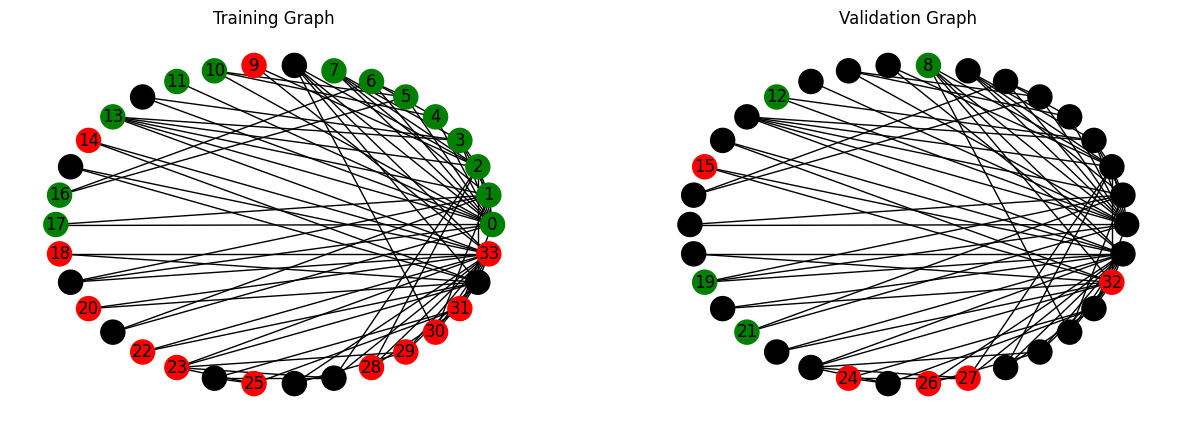

In [24]:
from sklearn.model_selection import train_test_split

# Features and labels
X = np.eye(34)
Y = np.array([[1, 0] if x == "Mr. Hi" else [0, 1] for x in labels])
As = A_norm.tocsr().sorted_indices().tocoo()
# Train validation mask to cover nodes in the training
index_karate = np.arange(34)
ind_train, ind_val = train_test_split(index_karate, test_size=0.25, random_state=42)
val_mask = np.zeros_like(index_karate)
train_mask = np.zeros_like(index_karate)
val_mask[ind_val] = 1
train_mask[ind_train] = 1
#Draw the graphs
plt.figure(figsize=(15, 5))
plt.subplot(121)
nx.draw_circular(G, with_labels=True, node_color=[x if train_mask[i] == 1 else "black" for i, x in enumerate(labels_color)])
plt.title("Training Graph")
plt.subplot(122)
nx.draw_circular(G, with_labels=True, node_color=[x if val_mask[i] == 1 else "black" for i, x in enumerate(labels_color)])
plt.title("Validation Graph")
plt.show()

We can use TensorFlow Keras API to train the model with some modifications. This is a somewhat hacky solution and not really as the Keras training API is intended. We directly insert the sparse matrix and Keras will think of the nodes as samples. We therefore have to fix the `batch_size=34`. Also we must prevent shuffling of the nodes (that will destroy our graph) and set `shuffle=False`. The covering of validation node labels can be realized with a `sample_weight=train_mask` that sets the validation nodes to zero in the loss (since nodes correspond to samples in this case).

In [25]:
# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    weighted_metrics=["categorical_accuracy"]
)

hist = model.fit(
    x=[As, X], y=Y,
    epochs=100,
    batch_size=34,
    verbose=1,
    shuffle=False,  # Since we do not really have batches, nodes must not be shuffled
    sample_weight=train_mask  # Important to hide values from
)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.5091 - categorical_accuracy: 0.5200
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 0.5074 - categorical_accuracy: 0.6400
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 0.5056 - categorical_accuracy: 0.9200
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 0.5038 - categorical_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 0.5020 - categorical_accuracy: 0.9600
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 0.5003 - categorical_accuracy: 0.9600
Epoch 7/100
1/1 [==============================] - 0s 15ms/step - loss: 0.4984 - categorical_accuracy: 0.9200
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 0.4965 - categorical_accuracy: 0.9200
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 0.4945 - categorical_accuracy: 0.8400
Epoch 10/100

In [26]:
val_loss = model.evaluate([As, X], Y, batch_size=34, sample_weight=val_mask)

1/1 [==============================] - 0s 266ms/step - loss: 0.0695 - categorical_accuracy: 0.8889


1/1 [==============================] - 0s 99ms/step


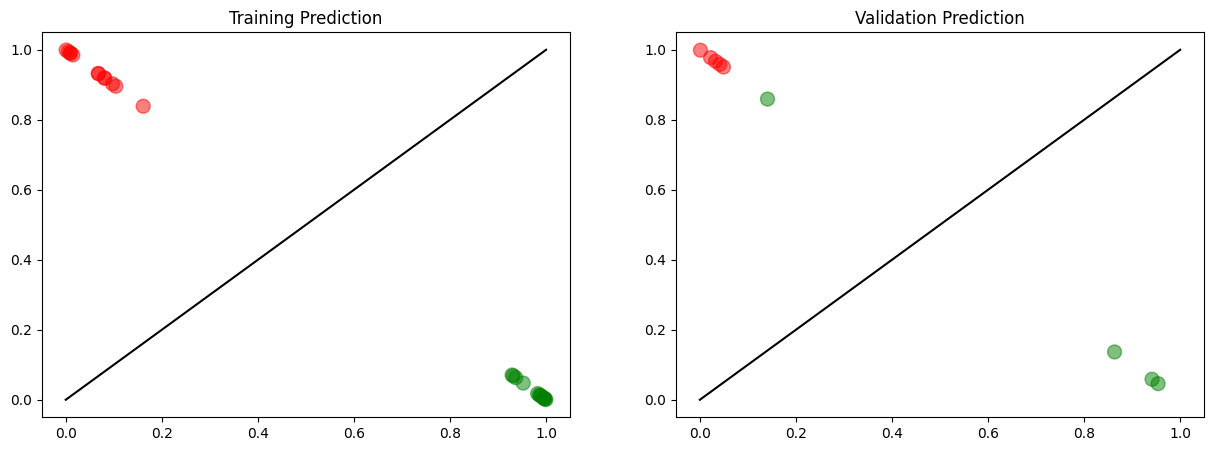

In [27]:
pred = model.predict([As, X], batch_size=34)
pred_val = pred[np.array(val_mask, dtype="bool")]
pred_train = pred[np.array(train_mask, dtype="bool")]
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.scatter(pred_train[:, 0], pred_train[:, 1], s=100, alpha=0.5,
            c=[x for i, x in enumerate(labels_color) if train_mask[i] == 1])
plt.plot((0, 1), c="black")
plt.title("Training Prediction")
plt.subplot(122)
plt.scatter(pred_val[:, 0], pred_val[:, 1], s=100, alpha=0.5, c=[x for i, x in enumerate(labels_color) if val_mask[i] == 1])
plt.title("Validation Prediction")
plt.plot((0, 1), c="black")
plt.show()

In [28]:
assert val_loss[-1] > 0.8
assert hist.history["categorical_accuracy"][-1] > 0.95

Why is it not surprising that the training accuracy approaches 1.0 ? But why is it interesting that the validation accuracy is high?

In [36]:
answer_training_acc = "Because the model is overfitting the training data, since we set shuffle=False"
answer_validation_acc = "Because it indicates, that the model is performing well on unseen data, it is a good indicator for the generalization performance of the model"

# YOUR CODE HERE
#raise NotImplementedError()

In [37]:
assert isinstance(answer_training_acc, str)
assert isinstance(answer_validation_acc, str)

# 10.2 Molecules
Molecules can also be represented as graphs. In this case we have many small(er) graphs and are interested in graph-embedding or graph classification rather than node embedding or classification. For this part we use the MUTAG dataset that classifies a set of small molecules as mutagenes.

In [38]:
import requests
import zipfile
import os

data_url = "https://ls11-www.cs.tu-dortmund.de/people/morris/graphkerneldatasets/MUTAG.zip"
if not os.path.exists("MUTAG.zip"):
    print("Downloading dataset ...")
    r = requests.get(data_url)
    _ = open("MUTAG.zip", "wb").write(r.content)
    print("Extracting dataset ...")
    archive = zipfile.ZipFile("MUTAG.zip", "r")
    archive.extractall()
    print("Extracting done.")

In [30]:
def read_mutag_text(filename):
    with open(filename, "r") as f:
        lines = f.read().split("\n")
    indices = [list(map(int, l.split(", "))) for l in lines if l]
    return np.array(indices, dtype="int")

In [31]:
# Read all mutag files
mutag_A = read_mutag_text("MUTAG/MUTAG_A.txt")
mutag_E = read_mutag_text("MUTAG/MUTAG_edge_labels.txt")
mutag_G = read_mutag_text("MUTAG/MUTAG_graph_indicator.txt")
mutag_N = read_mutag_text("MUTAG/MUTAG_node_labels.txt")
mutag_L = read_mutag_text("MUTAG/MUTAG_graph_labels.txt")

print("Shape of A:", mutag_A.shape)
print("Shape of Edges:", mutag_E.shape)
print("Shape of Graph-ID:", mutag_G.shape)
print("Shape of Nodes:", mutag_N.shape)
print("Shape of Graph-label:", mutag_L.shape)

# Want to start index from zero and not from 1
mutag_A -= 1
mutag_G -= 1

Shape of A: (7442, 2)
Shape of Edges: (7442, 1)
Shape of Graph-ID: (3371, 1)
Shape of Nodes: (3371, 1)
Shape of Graph-label: (188, 1)


In [32]:
# Separate the molecular graphs:
atom_code = ["C", "N", "O", "F", "I", "Cl", "Br"]
atom_color_map = {"C": "grey", "N": "green", "O": "blue", "F": "purple", "I": "yellow", "Cl": "pink", "Br": "orange"}
all_graphs = nx.Graph()
for i in range(len(mutag_N)):
    one_hot_atom_embedding = [0] * len(atom_code)  # There are 7 elements in the dataset
    one_hot_atom_embedding[mutag_N[i][0]] = 1
    str_atom_name = atom_code[mutag_N[i][0]]
    all_graphs.add_node(i,
                        features=one_hot_atom_embedding,
                        atom_name=str_atom_name)
for i in range(len(mutag_A)):
    one_hot_bond_embedding = [0] * 4  # There are 3 bond types in the dataset
    one_hot_bond_embedding[mutag_E[i][0]] = 1
    all_graphs.add_edge(mutag_A[i][0], mutag_A[i][1],
                        features=one_hot_bond_embedding)
graphs = []
nodes = np.arange(0, len(mutag_N), 1)
for g in range(0, np.amax(mutag_G)):
    graphs.append(all_graphs.subgraph(nodes[mutag_G[:, 0] == g]).to_directed())

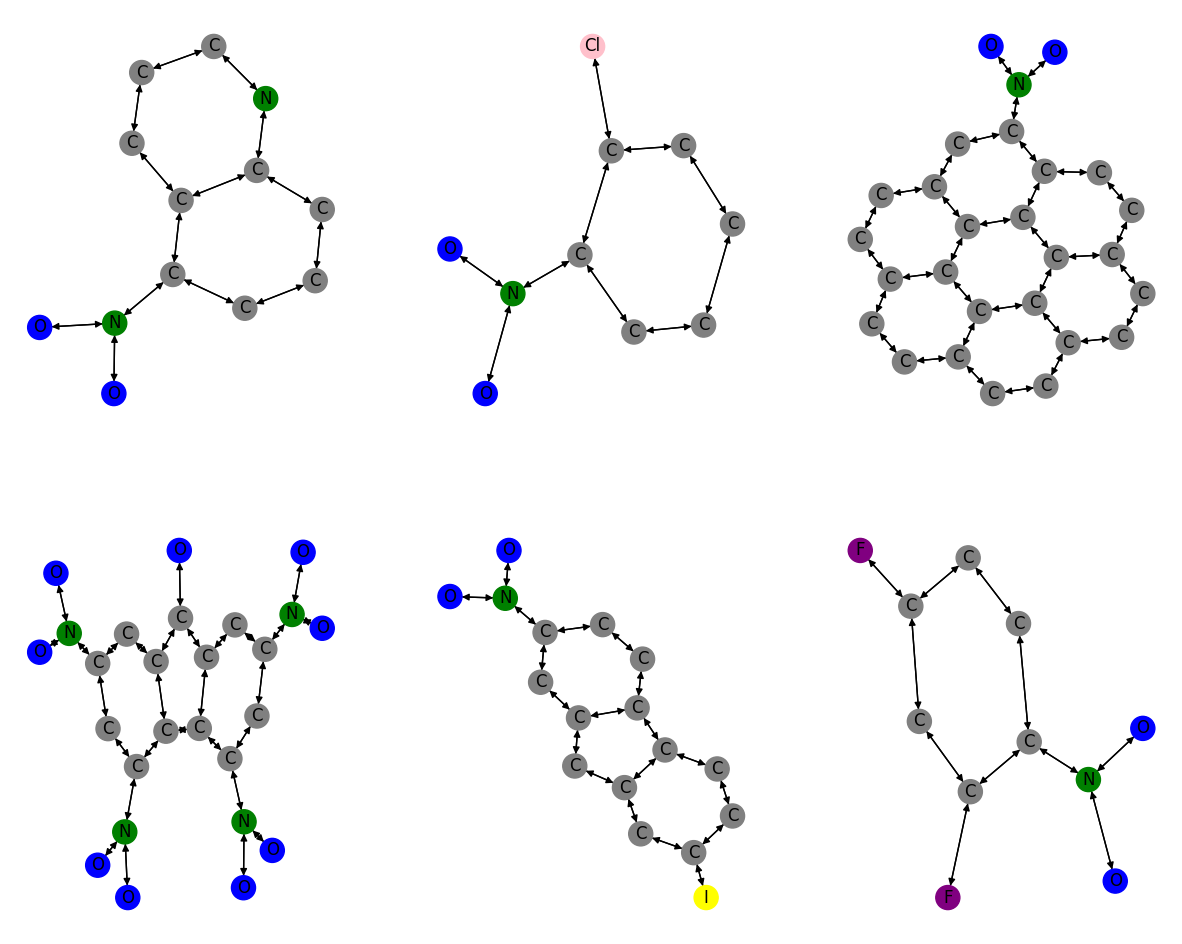

In [33]:
def plot_sub_graph(gri_plot):
    nx.draw(
        G=graphs[gri_plot],
        pos=nx.kamada_kawai_layout(graphs[gri_plot]),
        labels={n: (graphs[gri_plot].nodes()[n]["atom_name"]) for n in graphs[gri_plot].nodes()},
        node_color=[atom_color_map[graphs[gri_plot].nodes()[n]["atom_name"]] for n in graphs[gri_plot].nodes()]
    )


plt.figure(figsize=(15,12))
plt.subplot(231)
plot_sub_graph(2)
plt.subplot(232)
plot_sub_graph(75)
plt.subplot(233)
plot_sub_graph(23)
plt.subplot(234)
plot_sub_graph(101)
plt.subplot(235)
plot_sub_graph(21)
plt.subplot(236)
plot_sub_graph(123)

In [34]:
As = [nx.adjacency_matrix(graphs[i]) for i in range(len(graphs))]
Xs = [np.array([g.nodes()[n]["features"] for n in g.nodes()]) for g in graphs]

In [35]:
# Now we scale the matrix and already cast it to a dense array
# If you did not solve previous part you can do it with numpy functions here.
As = [compute_normalized_adj(a).toarray() for a in As]

To put multiple graphs of different size in a single tensor, we will use padding here. That means we simply fill up the tensor with zeros. However, since zeros can cause non-zero output (e.g. bias), a mask to ignore these values has to be added to the model. Keras also has masking capabilities for example for RNNs/LSTM and Masking passing between layers, but we will do it manually "by hand" or explicitly here.

In [39]:
A_padded = np.zeros((187, 28, 28))
A_mask = np.zeros((187, 28, 28), dtype="bool")

X_padded = np.zeros((187, 28, 7))
X_mask = np.zeros((187, 28, 1), dtype="bool")

for i, a in enumerate(As):
    # Fill A_padded, A_mask with correct values
    num_nodes = a.shape[0]
    A_padded[i, :num_nodes, :num_nodes] = a
    A_mask[i, :num_nodes, :num_nodes] = True

for i, x in enumerate(Xs):
    # Fill X_padded, X_mask with correct values
    num_nodes = x.shape[0]
    X_padded[i, :num_nodes, :] = x
    X_mask[i, :num_nodes, :] = True


labels = mutag_L
labels[labels == -1] = 0  # labels are in {-1, 1}, we want them as {0, 1}

In [40]:
test_arr_3 = np.array([
    [0.33333333, 0.33333333, 0.00000000, 0.00000000, 0.00000000],
    [0.33333333, 0.33333333, 0.28867513, 0.00000000, 0.00000000],
    [0.00000000, 0.28867513, 0.25000000, 0.25000000, 0.00000000],
    [0.00000000, 0.00000000, 0.25000000, 0.25000000, 0.28867513],
    [0.00000000, 0.00000000, 0.00000000, 0.28867513, 0.33333333]
])

test_arr_4 = np.array([1., 1., 1., 1., 1., 0., 0., 0., 0., 1.])

assert np.abs(A_padded[75, :5, :5] - test_arr_3).max() < 1e-4
assert np.abs(X_padded[75, :10, 0] - test_arr_4).max() < 1e-4

assert np.abs(A_padded[75, 10:, 10:]).max() < 1e-4
assert np.abs(X_padded[75, 10:, :]).max() < 1e-4

The model can be defined similar to the previous task (skeleton below). However, this time you can do the matrix multiplication with `tf.keras.layers.Dot` and applying the mask with `tf.keras.layers.Multiply`. We will derive a graph-embedding by simply averaging all the node-embeddings of the last layer. For this purpose, we use the `Pooling` layer after the graph convolutions.

In [41]:
import tensorflow as tf


class Pooling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Pooling, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        return tf.math.reduce_mean(inputs, axis=1)

In [43]:
# Model properties
hidden_dim = 32
target_dim = 1
depth = 3

# Model definition
input_adj = tf.keras.layers.Input(shape=(28, 28), name="adj_input", dtype="float32")
input_x = tf.keras.layers.Input(shape=(28, 7), name="atom_input", dtype="float32")
input_x_mask = tf.keras.layers.Input(shape=(28, 1), name="atom_mask", dtype="float32")
x = input_x
for i in range(depth):
    # Pseudo-Code of the model "x = D^-0.5*(A + I)*D^-0.5 * W *x"
    #
    # x = W*x (via tf.keras.layers.Dense(hidden_dim))
    # x = Mask(x) (via tf.keras.layers.Multiply())
    # x = A_scaled * x (via tf.keras.layers.Dot() think about the "axes" argument)
    # x = sigma(x) (via tf.keras.layers.Activation("relu"))
    # x = Mask(x) (via tf.keras.layers.Multiply())
    #
    x = tf.keras.layers.Dense(hidden_dim)(x)
    x = tf.keras.layers.Multiply()([x, input_x_mask])
    x = tf.keras.layers.Dot(axes=(2, 1))([input_adj, x])
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Multiply()([x, input_x_mask])

    #raise NotImplementedError()

x_pool = Pooling()(x)
out_classes = tf.keras.layers.Dense(target_dim, activation="sigmoid")(x_pool)
model = tf.keras.models.Model(inputs=[input_adj, input_x, input_x_mask], outputs=out_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom_input (InputLayer)        [(None, 28, 7)]      0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 28, 32)       256         ['atom_input[0][0]']             
                                                                                                  
 atom_mask (InputLayer)         [(None, 28, 1)]      0           []                               
                                                                                                  
 adj_input (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                            

In [44]:
# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    weighted_metrics=["accuracy"]
)
hist = model.fit(
    x=[A_padded, X_padded, X_mask],
    y=labels,
    epochs=500,
    batch_size=64,
    verbose=1,
    shuffle=True,
    validation_split=0.15
)

Epoch 1/500
3/3 [==============================] - 2s 145ms/step - loss: 0.7037 - accuracy: 0.3418 - val_loss: 0.6980 - val_accuracy: 0.2759
Epoch 2/500
3/3 [==============================] - 0s 24ms/step - loss: 0.6961 - accuracy: 0.3354 - val_loss: 0.6910 - val_accuracy: 0.7586
Epoch 3/500
3/3 [==============================] - 0s 25ms/step - loss: 0.6906 - accuracy: 0.6582 - val_loss: 0.6850 - val_accuracy: 0.7241
Epoch 4/500
3/3 [==============================] - 0s 24ms/step - loss: 0.6854 - accuracy: 0.6582 - val_loss: 0.6793 - val_accuracy: 0.7241
Epoch 5/500
3/3 [==============================] - 0s 23ms/step - loss: 0.6813 - accuracy: 0.6582 - val_loss: 0.6741 - val_accuracy: 0.7241
Epoch 6/500
3/3 [==============================] - 0s 24ms/step - loss: 0.6771 - accuracy: 0.6582 - val_loss: 0.6686 - val_accuracy: 0.7241
Epoch 7/500
3/3 [==============================] - 0s 23ms/step - loss: 0.6726 - accuracy: 0.6582 - val_loss: 0.6633 - val_accuracy: 0.7241
Epoch 8/500
3/3 [==

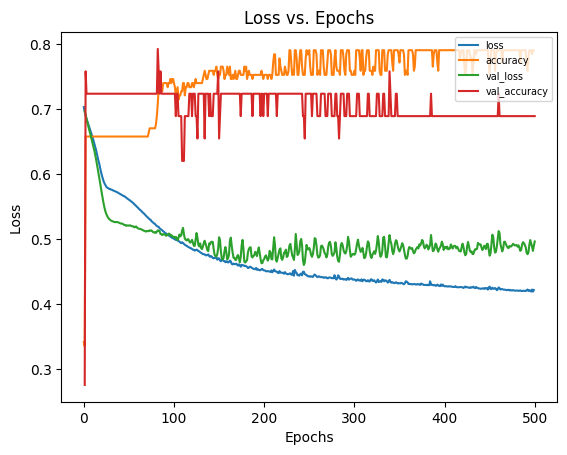

In [45]:
def plot_history(hist, validation_freq=1, scale=1):
    plt.figure()
    for key, loss in hist.history.items():
        np_loss = np.array(loss)
        if "val" in key:
            plt.plot(np.arange(np_loss.shape[0]) * validation_freq + validation_freq, np_loss, label=key)
        else:
            plt.plot(np.arange(np_loss.shape[0]), np_loss, label=key)

    plt.xlabel("Epochs")
    plt.ylabel("Loss ")
    plt.title("Loss vs. Epochs")
    plt.legend(loc="upper right", fontsize="x-small")
    plt.show()


plot_history(hist)

In [46]:
assert hist.history["accuracy"][-1] > 0.7
assert hist.history["val_accuracy"][-1] > 0.5